In [2]:
import os
import json
from functools import partial

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from shapely.geometry import shape
import folium
from folium import FeatureGroup
from folium.plugins import TimestampedGeoJson
import ipywidgets as widgets
from IPython.display import display, clear_output

pd.set_option('future.no_silent_downcasting', True)

# Election data

## Get Geography Data

In [3]:
# Load the data
df_geo = pd.read_csv('Data/raw/Geografi.csv', sep=';', decimal=',', na_values='-')
df_geo.columns = df_geo.columns.str.replace(' ', '', regex=True)

# Filter the data to only keep Copnhagen and its surroundings
df_geo_cph = df_geo.query("Storkredsnavn=='Københavns Storkreds'").drop_duplicates()
df_geo_cph['KredsNr'] = df_geo_cph['KredsNr'].astype(int)

# Keep only the necessary columns
df_geo_cph = df_geo_cph[['KredsNr', 'Kredsnavn','KommuneNr','Kommunenavn']]

# Replace Utterslev with Bispebjerg
df_geo_cph['Kredsnavn'] = df_geo_cph['Kredsnavn'].replace({'6. Utterslev':'6. Bispebjerg'})

In [4]:
kreds_split = df_geo_cph['Kredsnavn'].drop_duplicates().str.split('.', n=1, expand=True)
kreds_split.columns = ['ID', 'Name']
kreds_split['ID'] = kreds_split['ID'].astype(int)
kreds_split['Name'] = kreds_split['Name'].str.strip()  # Remove leading/trailing spaces
kreds_map = dict(zip(kreds_split['ID'], kreds_split['Name']))
kreds_name_map = {v: k for k, v in kreds_map.items()}

## Get Election Data

In [5]:
# Load the election data
df_elec_data = pd.read_csv('Data/raw/Valgdata.csv', sep=';' , decimal=',', na_values='-')
df_elec_data.columns = df_elec_data.columns.str.replace(' ', '', regex=True)

# Filter the election data to only keep the relevant KredsNr
df_elec_cph = df_elec_data[df_elec_data['KredsNr'].isin([str(k) for k in kreds_map.keys()])]
df_elec_cph.loc[:, 'KredsNr'] = df_elec_cph['KredsNr'].astype(int)

In [6]:
df_elec_cph

,Gruppe,KredsNr,StorKredsNr,LandsdelsNr,FV2015-Stemmeberettigede,FV2015-Afgivnestemmer,FV2015-Blankestemmer,FV2015-Andreugyldigestemmer,FV2015-Gyldigestemmer,FV2015-A.Socialdemokratiet,...,"FV2022-Q.FrieGrønne,DanmarksNyeVenstrefløjsparti",FV2022-Å.Alternativet,FV2022-2.Udenforpartierne,FV2022-3.Udenforpartierne,FV2022-P.StramKurs,FV2022-Æ.Danmarksdemokraterne-IngerStøjberg,FV2022-4.Udenforpartierne,FV2022-E.KlausRiskærPedersen,FV2022-5.Udenforpartierne,FV2022-6.Udenforpartierne
0,101002,1,1,1,53634.0,46748.0,312.0,142.0,46294.0,10634.0,...,529,4378,15.0,NaN,NaN,558,NaN,NaN,NaN,NaN
1,101009,2,1,1,44476.0,36980.0,327.0,155.0,36498.0,8223.0,...,1129,3771,22.0,NaN,NaN,812,NaN,NaN,NaN,NaN
2,101011,3,1,1,40705.0,34365.0,221.0,125.0,34019.0,6562.0,...,304,4068,20.0,NaN,NaN,338,NaN,NaN,NaN,NaN
3,101019,4,1,1,39746.0,32976.0,327.0,136.0,32513.0,7339.0,...,484,3229,14.0,NaN,NaN,739,NaN,NaN,NaN,NaN
4,101032,7,1,1,54683.0,45741.0,434.0,138.0,45169.0,11540.0,...,1658,3355,22.0,NaN,NaN,922,NaN,NaN,NaN,NaN
5,101046,8,1,1,35926.0,29781.0,297.0,120.0,29364.0,7432.0,...,897,2677,10.0,NaN,NaN,706,NaN,NaN,NaN,NaN
6,101051,9,1,1,42332.0,36095.0,282.0,105.0,35708.0,7038.0,...,742,5343,17.0,NaN,NaN,536,NaN,NaN,NaN,NaN
7,101058,5,1,1,55396.0,46714.0,366.0,170.0,46178.0,8061.0,...,1836,6947,26.0,NaN,NaN,358,NaN,NaN,NaN,NaN
8,101059,6,1,1,36085.0,28387.0,314.0,107.0,27966.0,6251.0,...,1273,3109,8.0,NaN,NaN,501,NaN,NaN,NaN,NaN
9,147004,10,1,1,37779.0,33675.0,254.0,97.0,33324.0,7134.0,...,349,2927,9.0,NaN,NaN,432,NaN,NaN,NaN,NaN


#### Format into long format

In [7]:
# Select vote cols (start with "FV")
vote_columns = [col for col in df_elec_cph.columns if col.startswith("FV")]

# Melt the dataframe to long format
df_elec_cph_long = df_elec_cph.melt(
    id_vars=['KredsNr'],
    value_vars=vote_columns,
    var_name='YearParty',
    value_name='Votes'
)

# Split the 'YearParty' column into 'Year' and 'Party'
df_elec_cph_long[['Year', 'Partyname']] = df_elec_cph_long['YearParty'].str.extract(r'FV(\d{4})-(.+)')

# Drop columns and reorder
df_elec_cph_long = df_elec_cph_long.drop(columns='YearParty')
df_elec_cph_long = df_elec_cph_long[['KredsNr', 'Year', 'Partyname', 'Votes']]

# Drop nan if the whole row is nan
df_elec_cph_long = df_elec_cph_long.dropna(how='all')

# Replace NaN values in Votes with 0
df_elec_cph_long['Votes'] = df_elec_cph_long['Votes'].fillna(0)

# Convert 'Year' and KredsNr to integer
df_elec_cph_long['Year'] = df_elec_cph_long['Year'].astype(int)
df_elec_cph_long['KredsNr'] = df_elec_cph_long['KredsNr'].astype(int)

In [8]:
df_elec_cph_long

,KredsNr,Year,Partyname,Votes
0,1,2015,Stemmeberettigede,53634.0
1,2,2015,Stemmeberettigede,44476.0
2,3,2015,Stemmeberettigede,40705.0
3,4,2015,Stemmeberettigede,39746.0
4,7,2015,Stemmeberettigede,54683.0
...,...,...,...,...
2011,5,2022,6.Udenforpartierne,0.0
2012,6,2022,6.Udenforpartierne,0.0
2013,10,2022,6.Udenforpartierne,0.0
2014,11,2022,6.Udenforpartierne,0.0


In [9]:
parties = ['A.Socialdemokratiet','B.DetRadikaleVenstre', 'C.DetKonservativeFolkeparti','D.Centrum-Demokraterne', 'F.SF-SocialistiskFolkeparti',
           'I.LiberalAlliance', 'K.Kristendemokraterne', 'O.DanskFolkeparti','M.Minoritetspartiet', 'V.Venstre,DanmarksLiberaleParti',
           'Y.NyAlliance', 'Ø.Enhedslisten-DeRød-Grønne','Q.FrieGrønne,DanmarksNyeVenstrefløjsparti','Å.Alternativet',   'P.StramKurs', 
           'Æ.Danmarksdemokraterne-IngerStøjberg', 'E.KlausRiskærPedersen']

blocks = {
    "left": ['A.Socialdemokratiet',
             'F.SF-SocialistiskFolkeparti',
             'Ø.Enhedslisten-DeRød-Grønne',
             'Q.FrieGrønne,DanmarksNyeVenstrefløjsparti',
             'Å.Alternativet',
             'B.DetRadikaleVenstre',
             'D.Centrum-Demokraterne',
             'M.Minoritetspartiet'],
    "right": ['C.DetKonservativeFolkeparti',
              'V.Venstre,DanmarksLiberaleParti',
              'I.LiberalAlliance',
              'O.DanskFolkeparti',
              'Æ.Danmarksdemokraterne-IngerStøjberg',
              'P.StramKurs',
              'K.Kristendemokraterne',
              'Y.NyAlliance',
              'E.KlausRiskærPedersen']}

In [10]:
df_elec_cph_long_filtered = df_elec_cph_long[df_elec_cph_long['Partyname'].isin(parties)].reset_index(drop=True)

In [11]:
df_elec_cph_long_filtered['block'] = df_elec_cph_long_filtered['Partyname'].apply(
    lambda x: 'left' if x in blocks['left'] else ('right' if x in blocks['right'] else 'other')
)

In [12]:
df_block_freq = df_elec_cph_long_filtered.groupby(['Year', 'block', 'KredsNr']).agg({'Votes': 'sum'})/df_elec_cph_long_filtered.groupby(['Year', 'KredsNr']).agg({'Votes': 'sum'})*100
df_block_freq = df_block_freq.reset_index().rename(columns={'Votes': 'Votes (%)'}).round(2)

In [13]:
df_party_freq = df_elec_cph_long_filtered.groupby(['Year', 'Partyname', 'KredsNr']).agg({'Votes': 'sum'})/df_elec_cph_long_filtered.groupby(['Year', 'KredsNr']).agg({'Votes': 'sum'})*100
df_party_freq = df_party_freq.reset_index().rename(columns={'Votes': 'Votes (%)'}).round(2)
df_party_freq

,Year,Partyname,KredsNr,Votes (%)
0,2005,A.Socialdemokratiet,1,20.45
1,2005,B.DetRadikaleVenstre,1,20.26
2,2005,C.DetKonservativeFolkeparti,1,10.69
3,2005,D.Centrum-Demokraterne,1,1.14
4,2005,E.KlausRiskærPedersen,1,0.00
...,...,...,...,...
1219,2022,"V.Venstre,DanmarksLiberaleParti",12,10.71
1220,2022,Y.NyAlliance,12,0.00
1221,2022,Å.Alternativet,12,2.75
1222,2022,Æ.Danmarksdemokraterne-IngerStøjberg,12,5.41


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define typical Danish party colors
party_colors = {
    'A.Socialdemokratiet': '#c9002c',       # Red
    'V.Venstre,DanmarksLiberaleParti': '#0066a1',  # Blue
    'B.DetRadikaleVenstre': '#EC008C',      # Purple
    'Ø.Enhedslisten-DeRød-Grønne': '#159F6B', #'#D0004D',   
    'F.SF-SocialistiskFolkeparti': '#C52E26',   # Magenta/Pink
    'C.DetKonservativeFolkeparti': '#00583C',   # Green
    'O.DanskFolkeparti': '#F6D40D'           # Yellow
}

# Filter top 5 parties per district by total votes
top_parties_per_district = (
    df_party_freq.groupby(['KredsNr', 'Partyname'])['Votes (%)'].sum()
    .reset_index()
    .sort_values(['KredsNr', 'Votes (%)'], ascending=[True, False])
    .groupby('KredsNr')
    .head(5)
)

df_top5 = pd.merge(
    df_party_freq, 
    top_parties_per_district[['KredsNr', 'Partyname']], 
    on=['KredsNr', 'Partyname']
)
df_top5['PartyLetter'] = df_top5['Partyname'].str.extract(r'^([A-ZÆØÅ])')

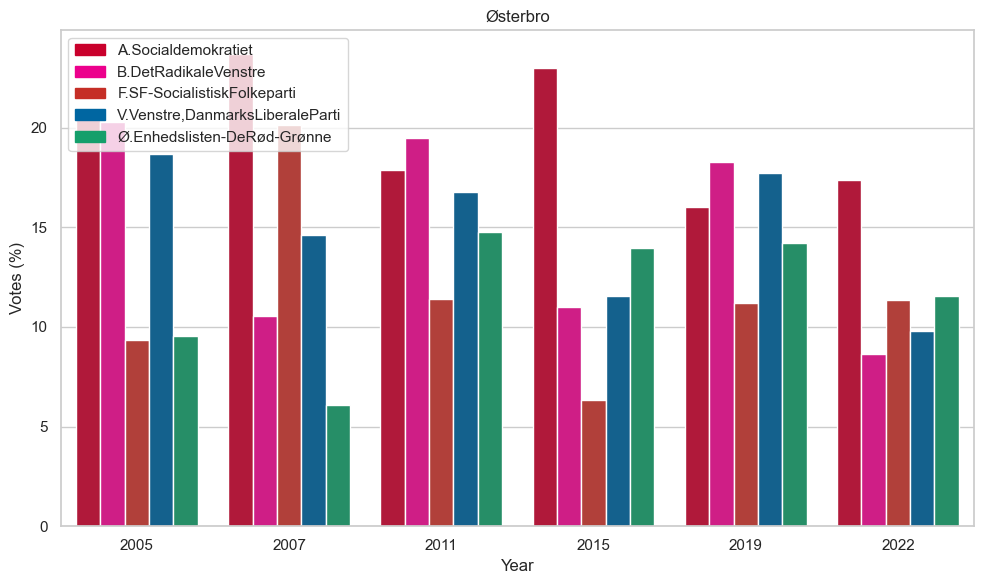

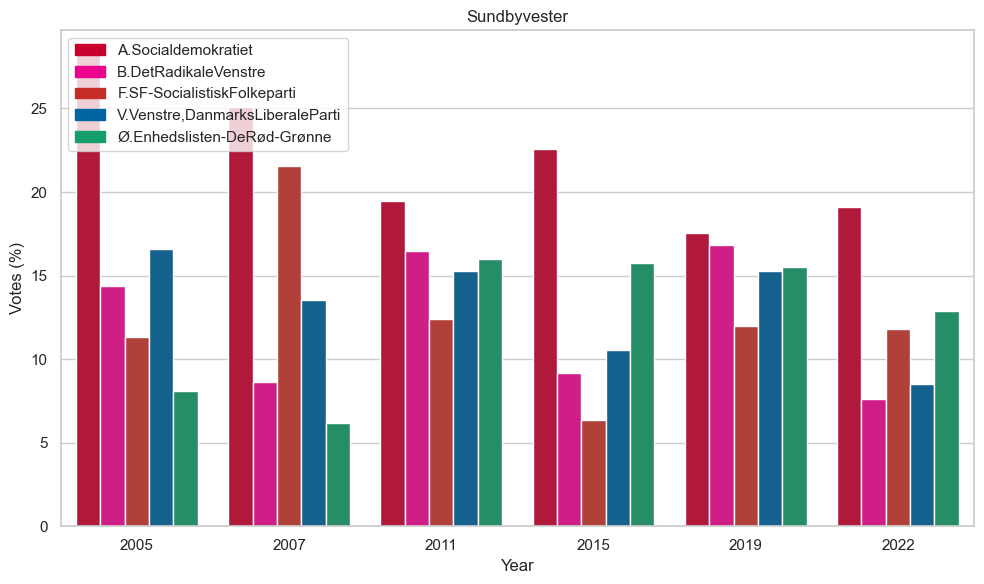

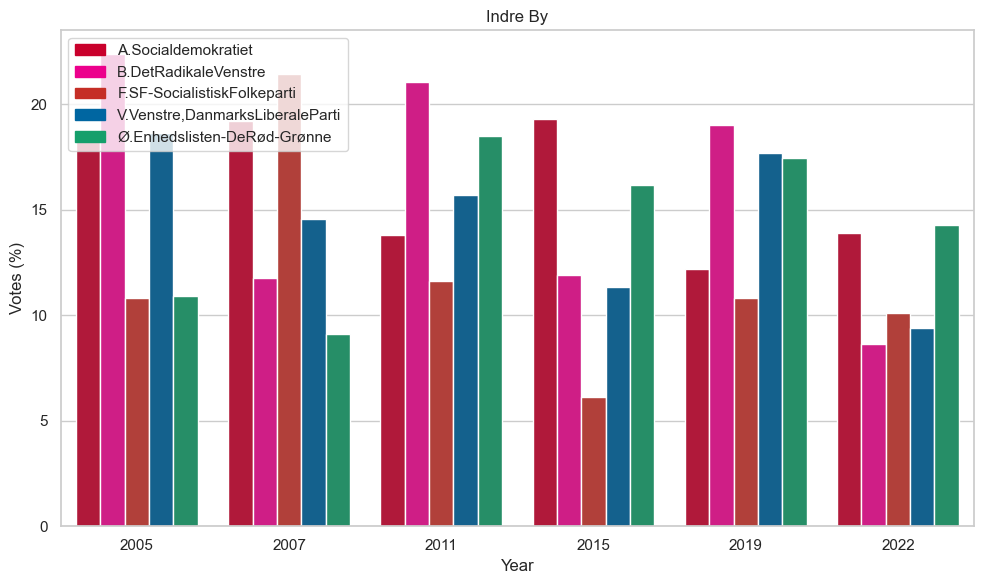

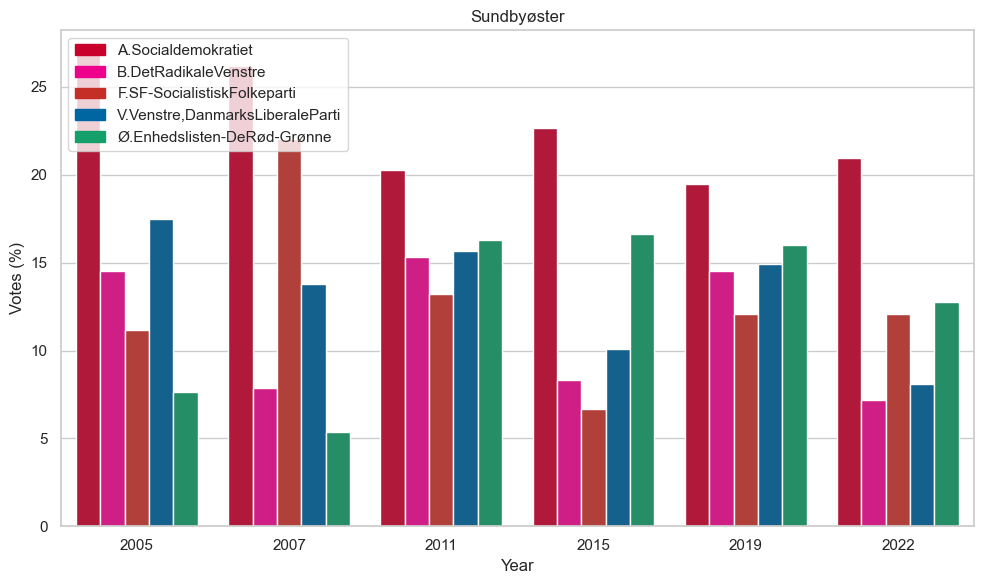

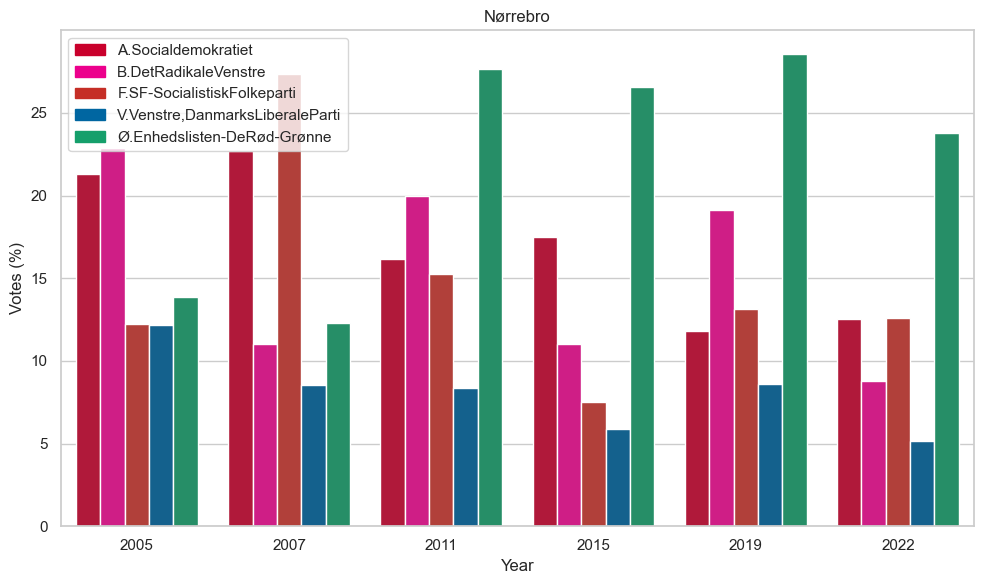

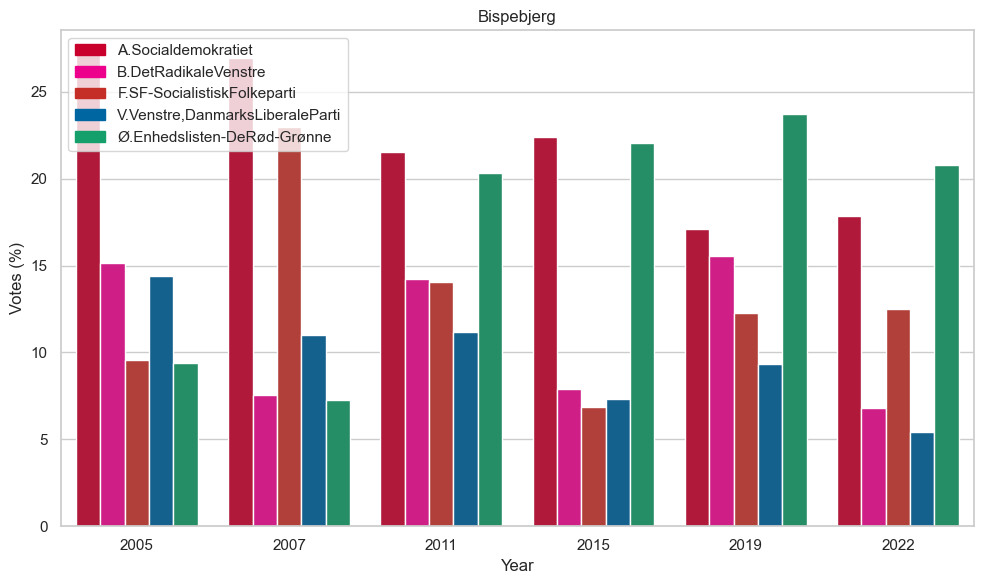

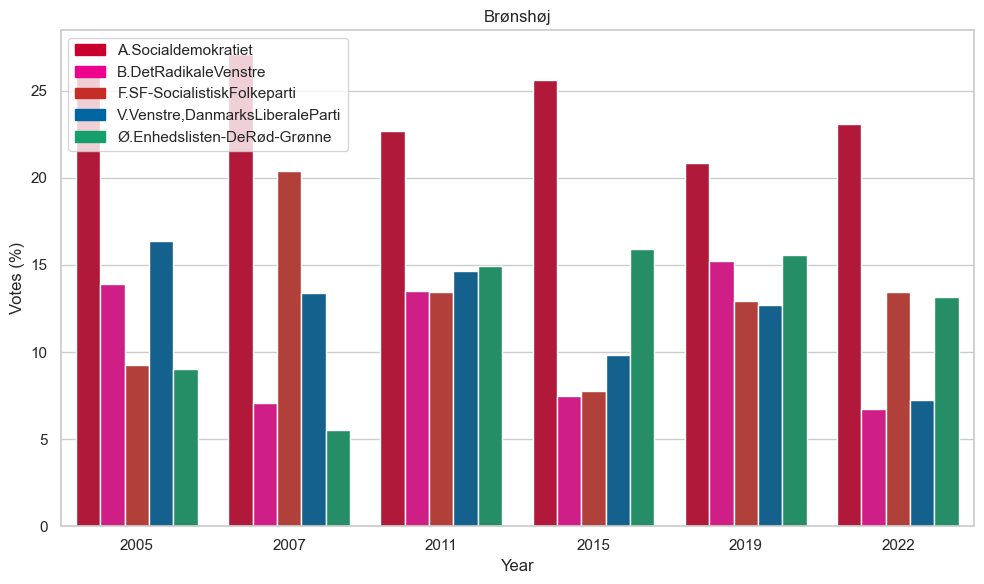

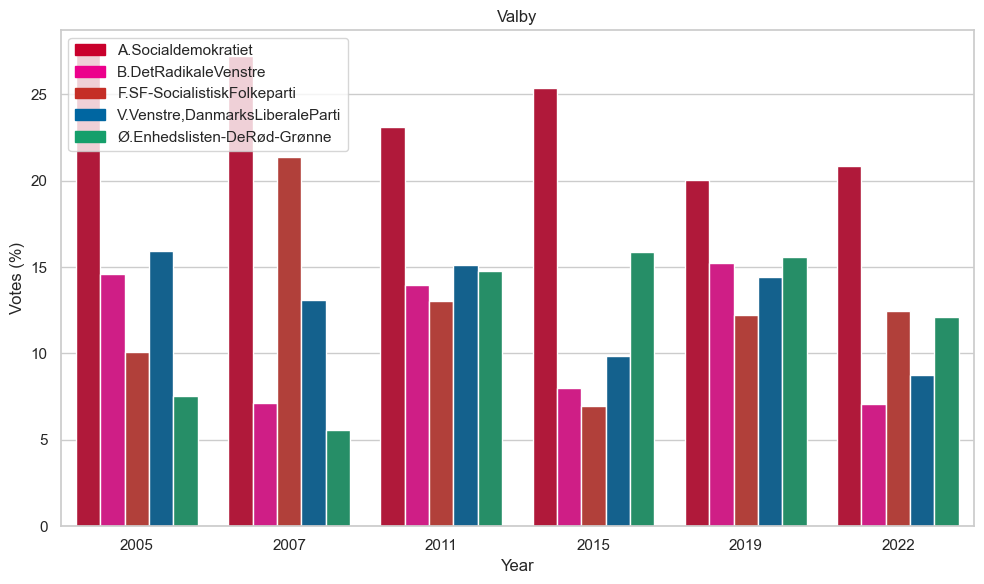

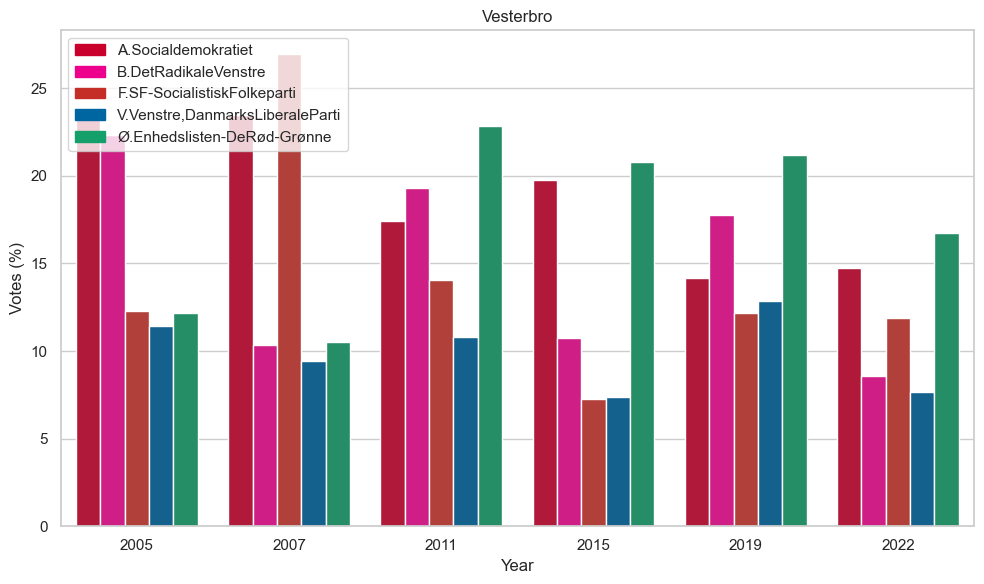

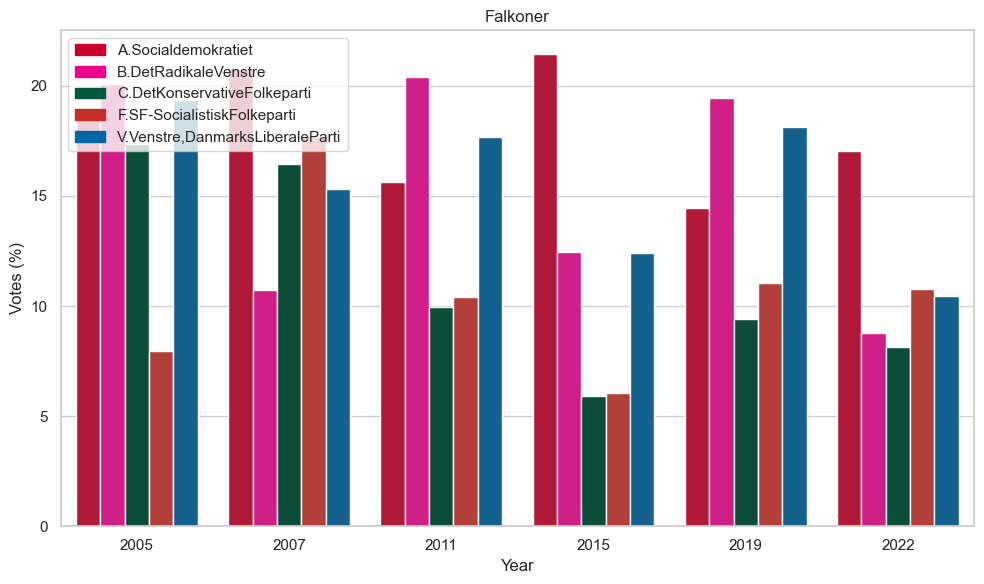

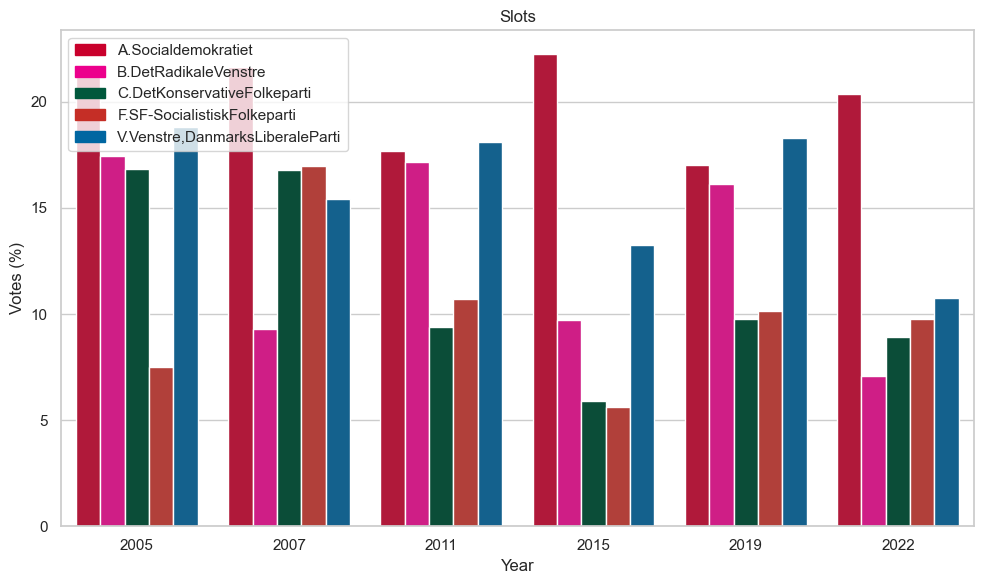

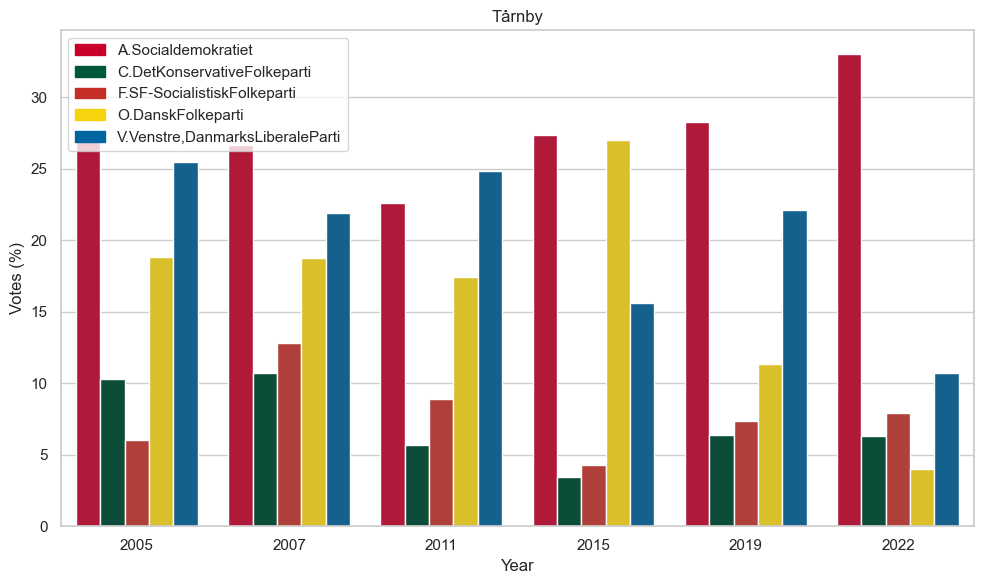

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

sns.set(style="whitegrid")

for kreds in sorted(df_top5['KredsNr'].unique()):
    fig, ax = plt.subplots(figsize=(10, 6))
    df_plot = df_top5[df_top5['KredsNr'] == kreds]
    
    sns.barplot(
        data=df_plot,
        x='Year', 
        y='Votes (%)', 
        hue='Partyname',
        palette=party_colors,
        ax=ax
    )
    
    ax.set_title(f'{kreds_map[kreds]}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Votes (%)')
    
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    present_parties = df_plot['Partyname'].unique()
    legend_handles = [
        mpatches.Patch(color=party_colors[party], label=party)
        for party in sorted(present_parties)
    ]
    
    # ✅ Legend on left side and no title
    ax.legend(
        handles=legend_handles,
        loc='upper left',
    )
    
    plt.tight_layout()
    if kreds_map[kreds] == 'Nørrebro': 
        plt.savefig('Nørrebro.png', dpi=300)
    
    plt.show()


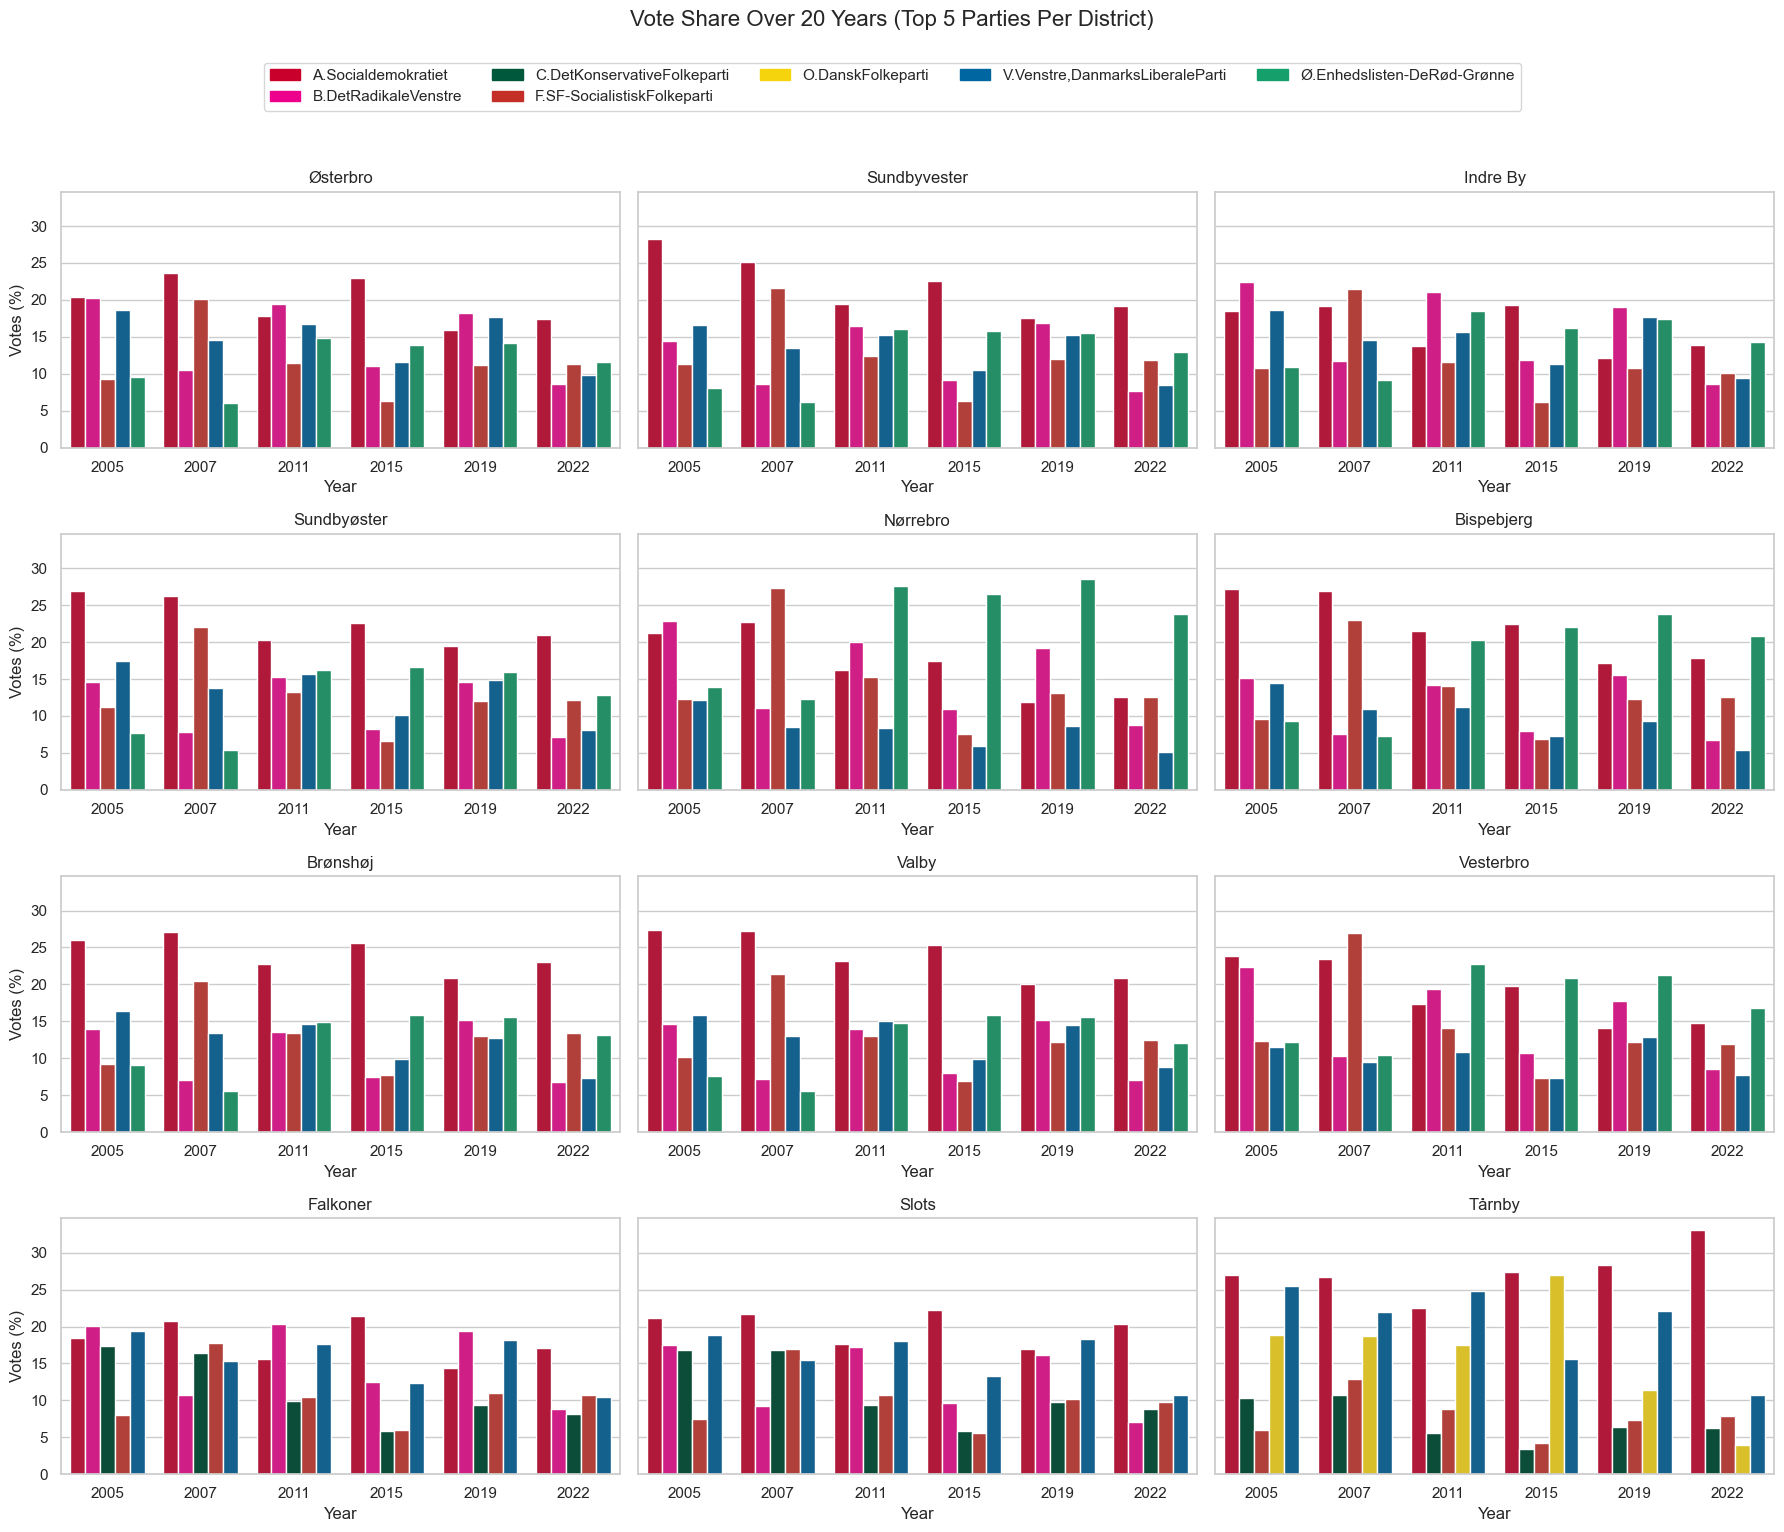

In [46]:
df_top5 = pd.merge(
    df_party_freq, 
    top_parties_per_district[['KredsNr', 'Partyname']], 
    on=['KredsNr', 'Partyname']
)
df_top5['PartyLetter'] = df_top5['Partyname'].str.extract(r'^([A-ZÆØÅ])')

# Set seaborn style
sns.set(style="whitegrid")

# Get the first 9 unique districts from your dataframe
kreds_list = sorted(df_top5['KredsNr'].unique())

# Create 3x3 subplots with no shared legend inside each subplot
fig, axes = plt.subplots(4, 3, figsize=(18, 15), sharey=True, sharex=False)
axes = axes.flatten()  # Flatten for easy iteration

for idx, kreds in enumerate(kreds_list):
    ax = axes[idx]
    df_plot = df_top5[df_top5['KredsNr'] == kreds]    

    # Create the barplot using the custom party_colors palette
    sns.barplot(
        data=df_plot,
        x='Year', 
        y='Votes (%)', 
        hue='Partyname',
        palette=party_colors,
        ax=ax
    )
    
    # Set the subplot title and axis labels
    ax.set_title(f'{kreds_map[kreds]}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Votes (%)')
    
    # Remove any subplot legend to avoid duplicate/confusing legends
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# Create a comprehensive shared legend manually using the party_colors mapping.
legend_handles = [
    mpatches.Patch(color=party_colors[party], label=party)
    for party in sorted(party_colors.keys())]

fig.suptitle('Vote Share Over 20 Years (Top 5 Parties Per District)', fontsize=16, y=1.02)

plt.subplots_adjust(top=0.20)
fig.legend(handles=legend_handles,loc='upper center',ncol=5, bbox_to_anchor=(0.5, 0.99))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [109]:
def blend_red_blue(pct_right):
    pct_right = min(max(pct_right, 0), 1)  # Clamp
    r = int((1 - pct_right) * 255)
    g = 0
    b = int(pct_right * 255)
    return f"#{r:02x}{g:02x}{b:02x}"

pivot = df_block_freq.pivot_table(
    index=["Year", "KredsNr"],
    columns="block",
    values="Votes (%)",
    fill_value=0
).reset_index()

pivot["pct_left"] = pivot["left"] / (pivot["right"] + pivot["left"])
pivot["pct_right"] = pivot["right"] / (pivot["right"] + pivot["left"])

geojson_folder = "Data/CopenhagenGeoData"

m = folium.Map(location=[55.6761, 12.5683], zoom_start=12, tiles="cartodbpositron")

for year in sorted(pivot["Year"].unique()):
    fg = FeatureGroup(name=str(year))

    df_year = pivot[pivot["Year"] == year]
    
    for _, row in df_year.iterrows():
        kreds_nr = row["KredsNr"]
        kreds_name = kreds_map.get(kreds_nr)
        if not kreds_name:
            continue

        pct_right = row["pct_right"]
        pct_left = row["pct_left"]
        fill_color = blend_red_blue(pct_right)

        geojson_path = os.path.join(geojson_folder, f"{kreds_name}.json")
        if not os.path.exists(geojson_path):
            continue

        with open(geojson_path, "r", encoding="utf-8") as f:
            geojson = json.load(f)
            geom = geojson["geometry"] 
            props = geojson["properties"]

        folium.GeoJson(
            data={
                "type": "Feature",
                "geometry": geom,
                "properties": {
                    "popup": f"{kreds_name} – {round(pct_left * 100)}% left"
                }
            },
            name=f"{kreds_name}_{year}",
            style_function=lambda x, c=fill_color: {
                "fillColor": c,
                "color": "black",
                "weight": 1,
                "fillOpacity": 1,
            },
            tooltip=folium.GeoJsonTooltip(fields=["popup"])
        ).add_to(fg)
        
        # Add kreds name and red/blue proportion bar at visual center from geojson
        vis_x = props.get("visueltcenter_x")
        vis_y = props.get("visueltcenter_y")
        if vis_x and vis_y:
            kreds_label_html = f'''
            <div style="text-align:center; font-size:11px;">
                <div style="font-weight:bold; margin-bottom:1px;">{kreds_name}</div>
                <div style="width:50px; height:8px; display:flex; border:1px solid #000; margin:auto;">
                    <div style="width:{round(pct_right * 100)}%; background-color:blue;"></div>
                    <div style="width:{round((1 - pct_right) * 100)}%; background-color:red;"></div>
                </div>
            </div>
            '''
            folium.map.Marker(
                location=[vis_y, vis_x],
                icon=folium.DivIcon(html=kreds_label_html)
            ).add_to(fg)


    fg.add_to(m)

folium.LayerControl(collapsed=False).add_to(m)  # Make it expanded by default
m.save("multi_year_map.html")

In [74]:
def blend_red_blue(pct_right):
    pct_right = min(max(pct_right, 0), 1)  # Clamp
    r = int((1 - pct_right) * 255)
    g = 0
    b = int(pct_right * 255)
    return f"#{r:02x}{g:02x}{b:02x}"

# Your processed data
pivot = df_block_freq.pivot_table(
    index=["Year", "KredsNr"],
    columns="block",
    values="Votes (%)",
    fill_value=0
).reset_index()

pivot["pct_left"] = pivot["left"] / (pivot["right"] + pivot["left"])
pivot["pct_right"] = pivot["right"] / (pivot["right"] + pivot["left"])

# Set up slicer (dropdown)
year_selector = widgets.Dropdown(
    options=sorted(pivot["Year"].unique()),
    description="Year:",
    style={"description_width": "initial"},
    layout=widgets.Layout(width="300px"))

output = widgets.Output()

def generate_map(year):
    m = folium.Map(location=[55.6761, 12.5683], zoom_start=12, tiles="cartodbpositron")
    df_year = pivot[pivot["Year"] == year]

    for _, row in df_year.iterrows():
        kreds_nr = row["KredsNr"]
        kreds_name = kreds_map.get(kreds_nr)
        if not kreds_name:
            continue

        pct_right = row["pct_right"]
        pct_left = row["pct_left"]
        fill_color = blend_red_blue(pct_right)

        geojson_path = os.path.join(geojson_folder, f"{kreds_name}.json")
        if not os.path.exists(geojson_path):
            continue

        with open(geojson_path, "r", encoding="utf-8") as f:
            geojson = json.load(f)
            geom = geojson["geometry"]

        folium.GeoJson(
            data={
                "type": "Feature",
                "geometry": geom,
                "properties": {
                    "popup": f"{kreds_name} – {round(pct_left * 100)}% left"
                }
            },
            style_function=lambda x, c=fill_color: {
                "fillColor": c,
                "color": "black",
                "weight": 1,
                "fillOpacity": 1,
            },
            tooltip=folium.GeoJsonTooltip(fields=["popup"])
        ).add_to(m)

    return m

def update_map(change):
    with output:
        clear_output(wait=True)
        selected_year = change["new"]
        m = generate_map(selected_year)
        display(m)

# Link the dropdown to the map update
year_selector.observe(update_map, names="value")

# # Show the widgets and map initially
# display(year_selector)
# with output:
#     display(generate_map(year_selector.value))
# display(output)

# Save the map to an HTML file
output_map = generate_map(year_selector.value)
output_map.save("CopenhagenElectionMap_layers_slicer.html")


In [ ]:
# # Add kreds name and red/blue proportion bar at visual center from geojson
# vis_x = props.get("visueltcenter_x")
# vis_y = props.get("visueltcenter_y")
# kreds_label_html = f'''
# <div style="text-align:center; font-size:11px;">
#     <div style="font-weight:bold; margin-bottom:1px;">{kreds_name}</div>
#     </div>
# </div>
# '''
# folium.map.Marker(
#     location=[vis_y, vis_x],
#     icon=folium.DivIcon(html=kreds_label_html)
# ).add_to(fg)

        
# title_html = """
# <div style="
#     position: absolute;
#     top: 50px;
#     right: 10px;
#     z-index: 9999;
#     background: white;
#     padding: 4px 10px;
#     border: 1px solid gray;
#     border-radius: 4px;
#     font-size: 14px;
#     font-weight: bold;
#     box-shadow: 1px 1px 4px rgba(0,0,0,0.2);
# ">
#     Select a Year
# </div>
# """
# m.get_root().html.add_child(folium.Element(title_html))

In [73]:
# Path to your GeoJSON folder
geojson_folder = "Data/CopenhagenGeoData"

# Create the base map centered on Copenhagen
copenhagen_map = folium.Map(location=[55.6761, 12.5683], zoom_start=12)


colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#aec7e8", "#ffbb78"
]

def style_function(feature, col):
    return {
        'fillColor': col,
        'color': 'black',
        'weight': 2,
        'fillOpacity': 0.6,
    }

# Add each GeoJSON file to the map
for i, filename in enumerate(os.listdir(geojson_folder)):
    if filename.endswith(".json"):
        path = os.path.join(geojson_folder, filename)
        
        with open(path, 'r', encoding='utf-8') as f:
            geojson_data = json.load(f)
        
        district_name = os.path.splitext(filename)[0]
        
        color = colors[i % len(colors)]  # cycle through colors
        
        folium.GeoJson(
            geojson_data,
            name=district_name,
            style_function=partial(style_function, col=color),
            tooltip=district_name
        ).add_to(copenhagen_map)
        
        # Extract centroid from 'geometry'
        geom = shape(geojson_data["geometry"])
        centroid = geom.centroid

        # Place district name at centroid
        folium.Marker(
            location=[centroid.y, centroid.x],
            icon=folium.DivIcon(
                html=f"""
                <div style="
                    font-size:10pt;
                    font-weight:bold;
                    text-align:center;
                    transform: translate(-50%, -50%);
                    white-space: nowrap;
                ">
                    {district_name}
                </div>
                """
            )
        ).add_to(copenhagen_map)
        

# Add layer control
folium.LayerControl().add_to(copenhagen_map)
# To save to file
copenhagen_map.save("copenhagen_districts_map.html")


## Get meta data for the parties

In [ ]:
# Load the parties metadata
df_parties_meta = pd.read_csv('ElectionData_DS/Partier.csv', sep=';')
df_parties_meta.columns = df_parties_meta.columns.str.replace(' ', '', regex=True)

In [11]:
df_parties_meta.head(5)

,Partinavn,Kortpartinavn,Parti,Nummer
0,Stemmeberettigede,Berret,BE,-5
1,Afgivne stemmer,Total,TO,-4
2,Blanke stemmer,Blanke,UB,-3
3,Andre ugyldige stemmer,Ugyldige,UA,-2
4,Gyldige stemmer,Gyldige,GY,-1


In [12]:
# Merge the election data with the parties metadata
df_elec_cph_long = pd.merge(
    df_elec_cph_long,
    df_parties_meta[['Partinavn', 'Kortpartinavn', 'Parti']],
    on='Partinavn',
    how='left'
)

In [13]:
# Merge with the geography data
df_elec_cph_long = pd.merge(
    df_elec_cph_long,
    df_geo_cph[['KredsNr', 'Kredsnavn', 'Kommunenavn']],
    on='KredsNr',
    how='left'
)

In [76]:
df_elec_cph_long.groupby('Year')['KredsNr'].nunique()

Year
2005    12
2007    12
2011    12
2015    12
2019    12
2022    12
Name: KredsNr, dtype: int64

# Population Data

In [18]:
# Load the election data
df_elec_data = pd.read_csv('Data/raw/Valgdata.csv', sep=';' , decimal=',', na_values='-')
df_elec_data.columns = df_elec_data.columns.str.replace(' ', '', regex=True)

# Filter the election data to only keep the relevant KredsNr
df_elec_cph = df_elec_data[df_elec_data['KredsNr'].isin([str(k) for k in kreds_map.keys()])]
df_elec_cph.loc[:, 'KredsNr'] = df_elec_cph['KredsNr'].astype(int)

In [19]:
# Load the population data
df_population = pd.read_csv("Data/raw/Befolkning.csv", sep=';', low_memory=False, decimal=',', na_values='-')
df_population.columns = df_population.columns.str.replace(' ', '', regex=True)

# Filter the population data to only keep the relevant KredsNr
df_population_cph = df_population[df_population['KredsNr'].isin([str(k) for k in kreds_map.keys()])]
df_population_cph.loc[:, 'KredsNr'] = df_population_cph['KredsNr'].astype(int)

In [20]:
# Drop columns with all NaN values
df_population_cph = df_population_cph.dropna(axis=1, how='all')
df_population_cph.fillna(0, inplace=True)
df_population_cph = df_population_cph.apply(pd.to_numeric, errors='coerce')

## Get demographics data

In [21]:
demographics_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Antalpersoneropgjortefter" in col
]

# Melt the DataFrame
df_pop_demographics = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=demographics_cols,
    var_name='RawColumn',
    value_name='Count'
)

# Extract the fields using regex
# Pattern: FV<year>-Antalpersoner..._<Gender><Age>_<CitizenshipCode>.<CitizenshipName>
df_pop_demographics[['Year', 'GenderAge', 'Citizenship']] = df_pop_demographics['RawColumn'].str.extract(
    r'FV(\d{4})-Antalpersoner.*?_(\w+\d+-?\d*år)_(?:\d+\.)?(.+)$'
)

# Separate Gender and Age
df_pop_demographics[['Gender', 'Age']] = df_pop_demographics['GenderAge'].str.extract(r'(\D+)(\d+-?\d*år)')

# Reorder and clean
df_pop_demographics = df_pop_demographics.drop(columns=['RawColumn', 'GenderAge'])
df_pop_demographics = df_pop_demographics[['Gruppe', 'KredsNr','Year', 'Gender', 'Age', 'Citizenship', 'Count']]

In [205]:
df_pop_demographics

,Gruppe,KredsNr,Year,Gender,Age,Citizenship,Count
0,101002,1,2015,Kvinder,0-4år,Danmark,2001.0
1,101009,2,2015,Kvinder,0-4år,Danmark,2172.0
2,101011,3,2015,Kvinder,0-4år,Danmark,1271.0
3,101019,4,2015,Kvinder,0-4år,Danmark,1539.0
4,101032,7,2015,Kvinder,0-4år,Danmark,2351.0
...,...,...,...,...,...,...,...
27643,101058,5,2022,Mænd,70-år,Uoplyst,3.0
27644,101059,6,2022,Mænd,70-år,Uoplyst,0.0
27645,147004,10,2022,Mænd,70-år,Uoplyst,2.0
27646,147006,11,2022,Mænd,70-år,Uoplyst,3.0


/var/folders/gq/83_83r9n6zbddrn0rsglnqj00000gn/T/ipykernel_13708/4228461413.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(abs(label))}" for label in ax.get_xticks()])
/var/folders/gq/83_83r9n6zbddrn0rsglnqj00000gn/T/ipykernel_13708/4228461413.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(abs(label))}" for label in ax.get_xticks()])
/var/folders/gq/83_83r9n6zbddrn0rsglnqj00000gn/T/ipykernel_13708/4228461413.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(abs(label))}" for label in ax.get_xticks()])
/var/folders/gq/83_83r9n6zbddrn0rsglnqj00000gn/T/ipykernel_13708/4228461413.py:59: UserWarning: set_ticklabels() should only be used with a fixed

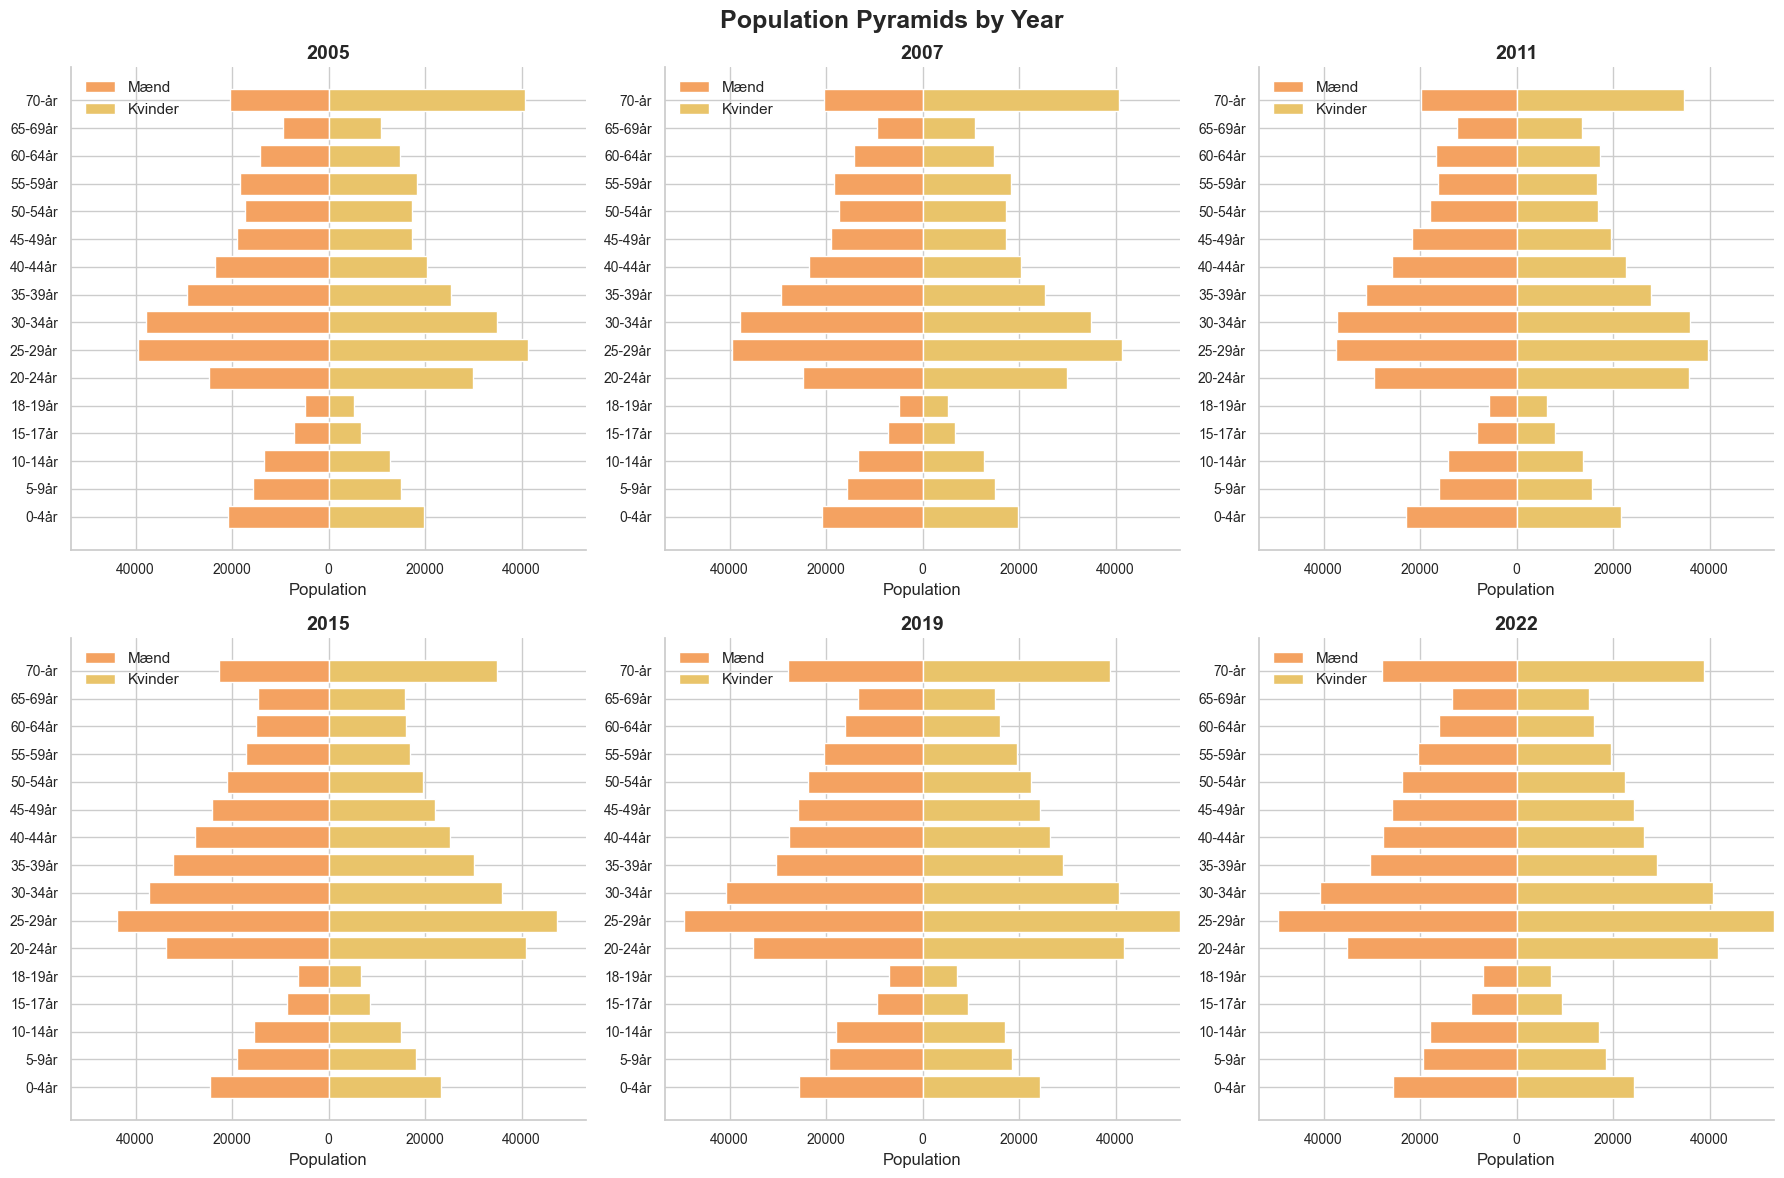

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Ensure Count is numeric
df_pop_demographics['Count'] = pd.to_numeric(df_pop_demographics['Count'], errors='coerce')

# Age order
age_order = [
    '0-4år', '5-9år', '10-14år', '15-17år', '18-19år', '20-24år',
    '25-29år', '30-34år', '35-39år', '40-44år', '45-49år',
    '50-54år', '55-59år', '60-64år', '65-69år', '70-år'
]

# Filter data
df = df_pop_demographics[
    df_pop_demographics['Gender'].isin(['Mænd', 'Kvinder']) &
    df_pop_demographics['Age'].isin(age_order)
]

# Color palette
color_m = '#F4A261'  # Warm orange
color_k = '#E9C46A'  # Soft yellow

# Setup subplots
years = sorted(df['Year'].unique())
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axs = axs.flatten()

# 🔥 Step 1: Calculate global max population count for consistent x-axis
max_count = 0
for year in years[:6]:
    df_year = df[df['Year'] == year]
    pop_by_age_gender = df_year.groupby(['Age', 'Gender'])['Count'].sum().unstack().fillna(0)
    max_year = pop_by_age_gender.values.max()
    if max_year > max_count:
        max_count = max_year

# 🔁 Step 2: Plot each year's pyramid
for i, year in enumerate(years[:6]):
    ax = axs[i]
    df_year = df[df['Year'] == year]

    # Group data
    pop_by_age_gender = df_year.groupby(['Age', 'Gender'])['Count'].sum().unstack().fillna(0)
    pop_by_age_gender = pop_by_age_gender.loc[age_order]

    # Plot bars
    ax.barh(pop_by_age_gender.index, -pop_by_age_gender['Mænd'], color=color_m, label='Mænd')
    ax.barh(pop_by_age_gender.index, pop_by_age_gender['Kvinder'], color=color_k, label='Kvinder')

    # Title and labels
    ax.set_title(f"{year}", fontsize=14, weight='bold')
    ax.set_xlabel('Population')
    ax.set_xlim(-max_count, max_count)
    ax.set_xticklabels([f"{int(abs(label))}" for label in ax.get_xticks()])

    # Legend
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=False)

    # Clean style
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

# Hide unused subplots
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

# Title and layout
plt.suptitle("Population Pyramids by Year", fontsize=18, weight='bold')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

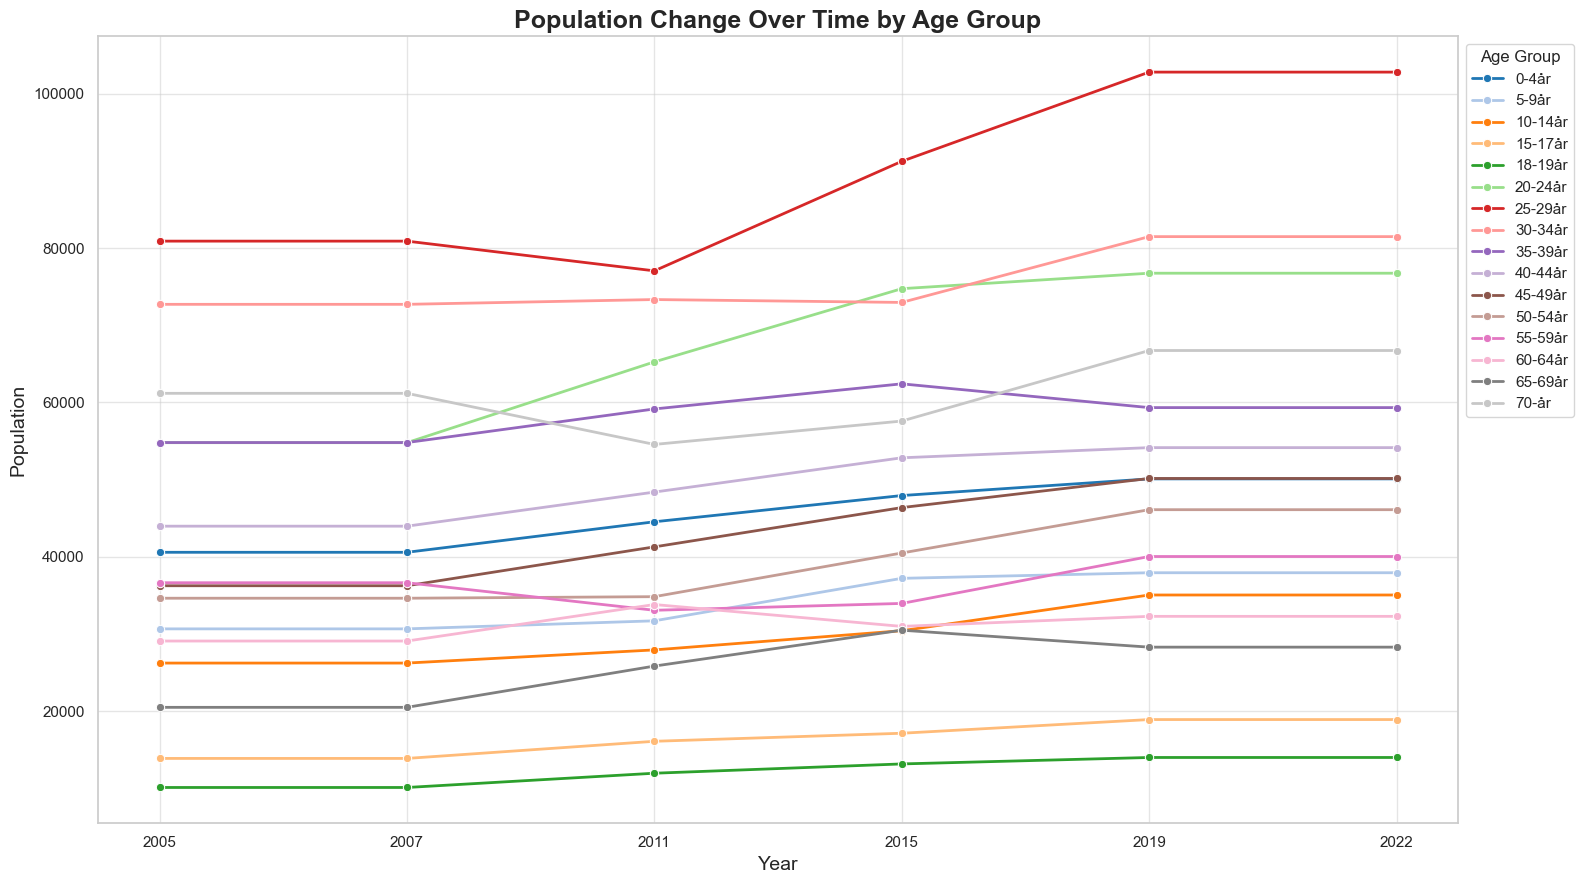

In [39]:
# Aggregate over both genders
df_age_year = df.groupby(['Year', 'Age'])['Count'].sum().reset_index()

# Define consistent age order
age_order = [
    '0-4år', '5-9år', '10-14år', '15-17år', '18-19år', '20-24år',
    '25-29år', '30-34år', '35-39år', '40-44år', '45-49år',
    '50-54år', '55-59år', '60-64år', '65-69år', '70-år'
]
df_age_year['Age'] = pd.Categorical(df_age_year['Age'], categories=age_order, ordered=True)

# Plot
plt.figure(figsize=(16, 9))
sns.lineplot(
    data=df_age_year,
    x='Year', y='Count', hue='Age', style='Age', marker='o', linewidth=2, dashes=False, palette='tab20',
)

last_year = int(df_age_year['Year'].max())  # <-- Fix here
for age in age_order:
    df_last = df_age_year[(df_age_year['Age'] == age) & (df_age_year['Year'] == last_year)]
    if not df_last.empty:
        y_val = df_last['Count'].values[0]
        plt.text(last_year + 0.2, y_val, age, fontsize=10, va='center')

# Titles and labels
plt.title('Population Change Over Time by Age Group', fontsize=18, weight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Population', fontsize=14)
plt.legend(title='Age Group', bbox_to_anchor=(1.0, 1), loc='upper left')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


## Get the housing size data

In [206]:
hoursing_size_columns = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "boligstørrelse" in col
]

# Melt to long format
df_house_size = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=hoursing_size_columns,
    var_name='RawColumn',
    value_name='Count'
)

# Extract year, aggregate level, and size category
df_house_size[['Year', 'AggregateLevel', 'HourseSize']] = df_house_size['RawColumn'].str.extract(
    r'FV(\d{4})-Boligerogpersonerefterboligstørrelse_\d+\.(?:Antal)?(boliger|personer)_(.+)'
)

df_house_size['AggregateLevel'] = df_house_size['AggregateLevel'].map({
    'boliger': 'Units',
    'personer': 'Residents'
})

# Reorder columns
df_house_size = df_house_size[[
    'Gruppe', 'KredsNr', 'Year', 'AggregateLevel', 'HourseSize', 'Count'
]]


In [219]:
df_house_size

,Gruppe,KredsNr,Year,AggregateLevel,HourseSize,Count
0,101002,1,2015,Units,0-39m2,1884.0
1,101009,2,2015,Units,0-39m2,2509.0
2,101011,3,2015,Units,0-39m2,1305.0
3,101019,4,2015,Units,0-39m2,1408.0
4,101032,7,2015,Units,0-39m2,1370.0
...,...,...,...,...,...,...
1003,101058,5,NaN,NaN,NaN,294.0
1004,101059,6,NaN,NaN,NaN,63.0
1005,147004,10,NaN,NaN,NaN,73.0
1006,147006,11,NaN,NaN,NaN,502.0


## Get the housing type data

In [208]:
# Identify relevant boligtype columns
housing_type_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Boligtype" in col
]

# Melt the DataFrame
df_housing_type = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=housing_type_cols,
    var_name='RawColumn',
    value_name='Count'
)

# Extract: year, aggregate level (boliger/personer), housing type
df_housing_type[['Year', 'AggregateLevel', 'HousingType']] = df_housing_type['RawColumn'].str.extract(
    r'FV(\d{4})-Boligtype_Antal_(boliger|personer)_\d+\.(.+)'
)

df_housing_type['AggregateLevel'] = df_housing_type['AggregateLevel'].map({
    'boliger': 'Units',
    'personer': 'Residents'
})

# Reorder columns if you want
df_housing_type = df_housing_type[[
    'Gruppe', 'KredsNr', 'Year', 'AggregateLevel', 'HousingType', 'Count'
]]


In [220]:
df_housing_type

,Gruppe,KredsNr,Year,AggregateLevel,HousingType,Count
0,101002,1,2015,Units,Stuehuseogparcelhuse,263.0
1,101009,2,2015,Units,Stuehuseogparcelhuse,2489.0
2,101011,3,2015,Units,Stuehuseogparcelhuse,163.0
3,101019,4,2015,Units,Stuehuseogparcelhuse,1807.0
4,101032,7,2015,Units,Stuehuseogparcelhuse,6377.0
...,...,...,...,...,...,...
907,101058,5,2022,Residents,Øvrigeboliger,364.0
908,101059,6,2022,Residents,Øvrigeboliger,355.0
909,147004,10,2022,Residents,Øvrigeboliger,213.0
910,147006,11,2022,Residents,Øvrigeboliger,609.0


## Get Ownership data

In [210]:
# Identify relevant boligtype columns
ownership_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Ejerforhold" in col
]

# Melt the DataFrame
df_ownership_type = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=ownership_cols,
    var_name='RawColumn',
    value_name='Count'
)

# Extract: year, aggregate level (boliger/personer), housing type
df_ownership_type[['Year', 'AggregateLevel', 'OwnershipType']] = df_ownership_type['RawColumn'].str.extract(
    r'FV(\d{4})-Ejerforhold_Antal_(boliger|personer)_\d+\.(.+)'
)

df_ownership_type['AggregateLevel'] = df_ownership_type['AggregateLevel'].map({
    'boliger': 'Units',
    'personer': 'Residents'
})

# Reorder columns if you want
df_ownership_type = df_ownership_type[[
    'Gruppe', 'KredsNr', 'Year', 'AggregateLevel', 'OwnershipType', 'Count'
]]


In [221]:
df_ownership_type

,Gruppe,KredsNr,Year,AggregateLevel,OwnershipType,Count
0,101002,1,2015,Units,Ejerbolig,6238.0
1,101009,2,2015,Units,Ejerbolig,6891.0
2,101011,3,2015,Units,Ejerbolig,4840.0
3,101019,4,2015,Units,Ejerbolig,6221.0
4,101032,7,2015,Units,Ejerbolig,11318.0
...,...,...,...,...,...,...
907,101058,5,2022,Residents,Øvrigebeboedeboliger,14464.0
908,101059,6,2022,Residents,Øvrigebeboedeboliger,10993.0
909,147004,10,2022,Residents,Øvrigebeboedeboliger,11822.0
910,147006,11,2022,Residents,Øvrigebeboedeboliger,14705.0


## Get Income data

In [212]:
# Step 1: Filter relevant income columns
income_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Husstandsindkomsterfordeltpåafstemningsområder" in col
]

# Step 2: Melt
df_income = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=income_cols,
    var_name='RawColumn',
    value_name='Value'
)

# Step 3: Extract Year + IncomeMetric
df_income[['Year', 'IncomeMetric']] = df_income['RawColumn'].str.extract(
    r'FV(\d{4})-Husstandsindkomsterfordeltpåafstemningsområder_(.+)'
)

# Step 4: Clean up
df_income = df_income.drop(columns='RawColumn')
df_income = df_income[[
    'Gruppe', 'KredsNr', 'Year', 'IncomeMetric', 'Value'
]]


In [222]:
df_income

,Gruppe,KredsNr,Year,IncomeMetric,Value
0,101002,1,2015,100.000-149.999kr,1717.0
1,101009,2,2015,100.000-149.999kr,1600.0
2,101011,3,2015,100.000-149.999kr,1074.0
3,101019,4,2015,100.000-149.999kr,1473.0
4,101032,7,2015,100.000-149.999kr,1263.0
...,...,...,...,...,...
811,101058,5,2022,Under100.000kr.,1740.0
812,101059,6,2022,Under100.000kr.,1024.0
813,147004,10,2022,Under100.000kr.,688.0
814,147006,11,2022,Under100.000kr.,764.0


## Get Education data

In [214]:
educ_columns = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Højstfuldførteerhvervsuddannelseogaldersgrupper" in col
]

# Melt the DataFrame
df_pop_educ = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=educ_columns,
    var_name='RawColumn',
    value_name='Count'
)

# Extract the fields using regex
# Pattern: FV<year>-Højstfuldførteer..._<Age>_<EducationLevel>
df_pop_educ[['Year', 'Age', 'EducationLevel']] = df_pop_educ['RawColumn'].str.extract(
    r'FV(\d{4})-Højstfuldførteerhvervsuddannelseogaldersgrupper_(\d{1,3}-?\d*år)(?:_(?:\d+\.)?(.+))?$'
)

# Remove 'år' from age
df_pop_educ['Age'] = df_pop_educ['Age'].str.replace('år', '', regex=False)

# Reorder and clean
df_pop_educ = df_pop_educ.drop(columns=['RawColumn'])
df_pop_educ = df_pop_educ[['Gruppe', 'KredsNr', 'Year', 'Age', 'EducationLevel', 'Count']]

# hvordan skal vi håndtere de manglende værdier i 'EducationLevel'?
# df_pop_educ['EducationLevel'] = df_pop_educ['EducationLevel'].fillna('Uoplyst')
# så skal vi summe count for Uoplyst og nan 

In [223]:
df_pop_educ

,Gruppe,KredsNr,Year,Age,EducationLevel,Count
0,101002,1,2015,18-19,Grundskole,854.0
1,101009,2,2015,18-19,Grundskole,763.0
2,101011,3,2015,18-19,Grundskole,635.0
3,101019,4,2015,18-19,Grundskole,638.0
4,101032,7,2015,18-19,Grundskole,1296.0
...,...,...,...,...,...,...
6907,101058,5,2022,70-,Uoplyst,279.0
6908,101059,6,2022,70-,Uoplyst,202.0
6909,147004,10,2022,70-,Uoplyst,218.0
6910,147006,11,2022,70-,Uoplyst,250.0


## Get Socio Economic data

In [216]:
# Select relevant columns for socio-economic status and industries
socioeconomic_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Socio-økonomiskstatusogbrancherfordeltpåafstemningsområder" in col
]

# Melt to long format
df_socio = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=socioeconomic_cols,
    var_name='RawColumn',
    value_name='Count'
)

# Extract Year, Employment Group, and Industry
df_socio[['Year', 'EmploymentGroup', 'Industry']] = df_socio['RawColumn'].str.extract(
    r'FV(\d{4})-Socio-økonomiskstatusogbrancherfordeltpåafstemningsområder_\d+\.(.+?)_(.+)'
)

# Clean up columns
df_socio = df_socio.drop(columns=['RawColumn'])
df_socio = df_socio[['Gruppe', 'KredsNr', 'Year', 'EmploymentGroup', 'Industry', 'Count']]


In [224]:
df_socio

,Gruppe,KredsNr,Year,EmploymentGroup,Industry,Count
0,101002,1,2015,Selvstændigogmedhj.,Byggeoganlæg,135.0
1,101009,2,2015,Selvstændigogmedhj.,Byggeoganlæg,107.0
2,101011,3,2015,Selvstændigogmedhj.,Byggeoganlæg,77.0
3,101019,4,2015,Selvstændigogmedhj.,Byggeoganlæg,122.0
4,101032,7,2015,Selvstændigogmedhj.,Byggeoganlæg,223.0
...,...,...,...,...,...,...
5755,101058,5,2022,Øvrige(offentligtforsørgede),Uoplystaktivitet,31846.0
5756,101059,6,2022,Øvrige(offentligtforsørgede),Uoplystaktivitet,23856.0
5757,147004,10,2022,Øvrige(offentligtforsørgede),Uoplystaktivitet,23428.0
5758,147006,11,2022,Øvrige(offentligtforsørgede),Uoplystaktivitet,22785.0


## Get support data

In [36]:
support_cols = [
    col for col in df_population_cph.columns
    if col.startswith("FV") and "Personerefterforsørgelsestype" in col
]

# Melt the DataFrame
df_support = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=support_cols,
    var_name='RawColumn',
    value_name='Count'
)

# Extract Year and SupportType
df_support[['Year', 'SupportType']] = df_support['RawColumn'].str.extract(
    r'FV(\d{4})-Personerefterforsørgelsestype_\d+\.(.+)'
)

# Clean up
df_support = df_support.drop(columns='RawColumn')
df_support = df_support[['Gruppe', 'KredsNr', 'Year', 'SupportType', 'Count']]


In [37]:
df_support.head(3)

,Gruppe,KredsNr,Year,SupportType,Count
0,101002,1,2015,Arbejdsløshedsdagpenge,4618
1,101009,2,2015,Arbejdsløshedsdagpenge,4029
2,101011,3,2015,Arbejdsløshedsdagpenge,2966


## Get origin data

In [38]:
# Filter relevant columns
origin_cols = [
    col for col in df_population_cph.columns
    if "Indvandrereogefterkommerefordeltefteroprindelsesland" in col
]

# Melt to long format
df_origin_long = df_population_cph.melt(
    id_vars=['Gruppe', 'KredsNr'],
    value_vars=origin_cols,
    var_name='RawColumn',
    value_name='Count'
)

# Extract year, gender, age, origin
df_origin_long[['Year', 'GenderAge', 'Origin']] = df_origin_long['RawColumn'].str.extract(
    r'FV(\d{4})-Indvandrereogefterkommerefordeltefteroprindelsesland_(\D+\d+-?\d*år)_(?:\d+\.)?(.+)$'
)

# Split gender and age
df_origin_long[['Gender', 'Age']] = df_origin_long['GenderAge'].str.extract(r'(\D+)(\d+-?\d*år)')

# Clean up
df_origin_long = df_origin_long.drop(columns=['RawColumn', 'GenderAge'])
df_origin_long['Age'] = df_origin_long['Age'].str.replace('år', '', regex=False)


In [39]:
df_origin_long.head(3)

,Gruppe,KredsNr,Count,Year,Origin,Gender,Age
0,101002,1,20,2015,Nordiskelande,Kvinder,0-4
1,101009,2,36,2015,Nordiskelande,Kvinder,0-4
2,101011,3,22,2015,Nordiskelande,Kvinder,0-4
